<a href="https://colab.research.google.com/github/hectic97/Boostcamp-AI-Tech/blob/main/U-stage/Week8/pruning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 주안점
#### Pruning 전/후 model size 비교

- [참고] https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

Authored by: 진영화 jyh2378@gmail.com

In [1]:
###### Check GPU runtime is enabled

import os
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# 모델 생성
먼저 프루닝을 수행하기 위한 간단한 모델을 생성하고 훈련시켜 봅시다.

모델은 LeNet5, 데이터는 Mnist를 사용하겠습니다.

<center><img src='https://t1.daumcdn.net/cfile/tistory/99170D4C5C7E21250E' width=70%></center>

<center> <em>LeNet5의 구조</em></center>

In [4]:
train_loader = DataLoader(torchvision.datasets.CIFAR10('../data', train=True, download=True,
                                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                    ])),
               batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

test_loader = DataLoader(torchvision.datasets.CIFAR10('../data', train=False, 
                                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                    ])),
              batch_size=64, shuffle=False, num_workers=1, pin_memory=True)


Extracting ../data/cifar-10-python.tar.gz to ../data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 0, 7, 6, 2, 9, 7, 9, 3, 2, 2, 3, 8, 4, 8, 6, 2, 3, 1, 8])


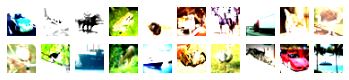

In [10]:
# show some sample images
import numpy as np

images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

figure = plt.figure() #image_caption
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().transpose(1,2,0).squeeze(), cmap='gray_r')
print(labels[1:21])

In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(576, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

In [22]:
def train(args, model, device, train_loader, optimizer, criterion, epoch):
    """ Train the model with given dataset
    
    Args:
        args: args like log interval
        model: ResNet model to train
        device: CPU/GPU
        train_loader: dataset iterator
        optimizer: optimizer to update weights
        epoch: number of epochs to train for
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [23]:
batch_size = 64
epochs = 10
lr = 0.001
momentum = 0.9
seed = 1
log_interval = 500
save_model = True
no_cuda = False

use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
model = LeNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
args = {}
args["log_interval"] = log_interval
for epoch in range(1, epochs + 1):
    train(args, model, device, train_loader, optimizer, criterion, epoch)

if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.300841
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.484489
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.394825
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.593757
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.346398
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.359072
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.042976
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.942786
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.064879
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.920342
Train Epoch: 6 [0/50000 (0%)]	Loss: 0.891386
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.000265
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.947973
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.307106
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.938511
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.947997
Train Epoch: 9 [0/50000 (0%)]	Loss: 1.006714
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.861046
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.877800
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.104817


In [24]:
def print_size_of_model(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')
  
print_size_of_model(model)

Size of the model(MB): 0.328649


In [25]:
def test(model, device, test_loader, quantize=False, fbgemm=False):
    model.to(device)
    model.eval()
    print(model)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            st = time.time()
            output = model(data)
            et = time.time()
            test_loss += F.nll_loss(F.log_softmax(output, dim=-1), target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

In [26]:
device = 'cpu'
test(model=model, device=device, test_loader=test_loader)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 0.328585

Test set: Average loss: 1.0419, Accuracy: 6402/10000 (64%)

Elapsed time = 2.4292 milliseconds


# 레이어 weight 확인
먼저 생성된 모델의 첫 번째 레이어를 구성하는 파라미터 들을 확인해봅시다.
weight와 bias로 구성이 되어 있는 것을 확인할 수 있습니다.

In [27]:
module = model.conv1
print(list(module.named_parameters())) # will not change even after pruning
print(module.weight) # now it is the same as module.named_parameters()

[('weight', Parameter containing:
tensor([[[[ 0.2024, -0.1096, -0.0591],
          [ 0.0960, -0.3782,  0.1715],
          [-0.1034,  0.0725,  0.1319]],

         [[ 0.0739, -0.0114, -0.0540],
          [ 0.0949, -0.2900,  0.0435],
          [-0.0695,  0.0064,  0.1052]],

         [[ 0.2391,  0.0035, -0.0984],
          [-0.0721, -0.2251,  0.0179],
          [-0.0910,  0.0180,  0.2372]]],


        [[[ 0.1354, -0.1102,  0.1989],
          [ 0.0864,  0.2606,  0.1899],
          [-0.2727, -0.3303, -0.1454]],

         [[ 0.1770,  0.0107,  0.1193],
          [-0.0953,  0.2146, -0.0885],
          [ 0.0197, -0.1974, -0.2109]],

         [[ 0.1478, -0.0241,  0.1199],
          [-0.0054,  0.0543, -0.1415],
          [-0.1349, -0.0109, -0.0577]]],


        [[[ 0.1499,  0.2650, -0.0123],
          [-0.0983,  0.2945,  0.1187],
          [-0.1224,  0.1955,  0.1845]],

         [[-0.0017, -0.0910, -0.1106],
          [-0.1587,  0.0769, -0.1918],
          [-0.3392,  0.0222, -0.0985]],

         [

In [28]:
# Check named_buffer is empty
print(list(module.named_buffers()))  # now the buffer is empty. It will show up after being pruned.

[]


In [29]:
output_orig = model(images[:1])
print(f"original output: {output_orig}")

original output: tensor([[ 0.0143, -5.5676, -0.3807,  0.4022, -1.7623, -0.8912, -1.1366, -5.3665,
          3.3781, -3.2475]], grad_fn=<AddmmBackward>)


# Unstructured Pruning
기본적인 프루닝 방법은 스칼라 단위의 값(=하나의 숫자)에 대해 프루닝을 하는 것입니다.

Pytorch에서 제공하는 prune method를 이용하여 이를 수행해보겠습니다.
프루닝할 값을 고르는 방법 또한 여러가지입니다만, 우선 random으로 선택하는 방식을 적용해 보겠습니다.

In [30]:
import torch.nn.utils.prune as prune

In [31]:
prune.random_unstructured(module, name="weight", amount=0.3)

Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))

In [32]:
print(list(module.named_parameters()))

[('bias', Parameter containing:
tensor([ 0.0359,  0.0059, -0.0366,  0.1202, -0.1031,  0.0273],
       requires_grad=True)), ('weight_orig', Parameter containing:
tensor([[[[ 0.2024, -0.1096, -0.0591],
          [ 0.0960, -0.3782,  0.1715],
          [-0.1034,  0.0725,  0.1319]],

         [[ 0.0739, -0.0114, -0.0540],
          [ 0.0949, -0.2900,  0.0435],
          [-0.0695,  0.0064,  0.1052]],

         [[ 0.2391,  0.0035, -0.0984],
          [-0.0721, -0.2251,  0.0179],
          [-0.0910,  0.0180,  0.2372]]],


        [[[ 0.1354, -0.1102,  0.1989],
          [ 0.0864,  0.2606,  0.1899],
          [-0.2727, -0.3303, -0.1454]],

         [[ 0.1770,  0.0107,  0.1193],
          [-0.0953,  0.2146, -0.0885],
          [ 0.0197, -0.1974, -0.2109]],

         [[ 0.1478, -0.0241,  0.1199],
          [-0.0054,  0.0543, -0.1415],
          [-0.1349, -0.0109, -0.0577]]],


        [[[ 0.1499,  0.2650, -0.0123],
          [-0.0983,  0.2945,  0.1187],
          [-0.1224,  0.1955,  0.1845]],

 

기존 레이어는 'weight', 'bias'로 구성이 되어있었던 파라미터가 'weight_orig', 'bias'라는 이름으로 바뀐 것을 볼 수 있습니다. 'weight'가 'weight_orig'라는 이름으로 바뀌었네요

하지만 값은 전혀 변한 것이 없습니다. 그러면 무엇이 수행이 된 것일까요?

In [33]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[1., 0., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [0., 1., 1.],
          [1., 0., 1.]],

         [[0., 1., 1.],
          [1., 1., 1.],
          [1., 0., 0.]]],


        [[[0., 0., 1.],
          [1., 0., 1.],
          [1., 1., 0.]],

         [[0., 1., 1.],
          [1., 1., 0.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 0.],
          [0., 0., 1.]]],


        [[[1., 0., 0.],
          [0., 1., 0.],
          [1., 1., 1.]],

         [[0., 1., 0.],
          [0., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 0.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 0.],
          [1., 0., 1.],
          [0., 1., 1.]],

         [[1., 0., 1.],
          [1., 1., 1.],
          [1., 0., 0.]],

         [[1., 1., 1.],
          [1., 0., 0.],
          [1., 0., 1.]]],


        [[[1., 1., 1.],
          [0., 0., 1.],
          [0., 0., 1.]],

         [[1.

prune 함수를 수행하고 나면, 레이어의 named_buffers()에 'weight_mask'라는 새로운 파라미터가 하나 생성된 것을 볼 수 있습니다.


프루닝이라면 일반적으로 특정 값을 0으로 만들어 영향력을 없애는 것으로 생각할 수 있습니다. 하지만 pytorch에서는 직접 값을 바로 0으로 바꾸는 대신, mask 텐서를 추가로 생성하여 프루닝을 수행하게 됩니다. 삭제할 값을 0, 보존할 값을 1로 설정한 mask 텐서를 생성한 후, 실제 계산을 수행할때 mask와 weight를 원소별로 곱한 텐서를 활용하게 되지요.

pruning mask가 적용된 weight의 결과는 레이어의 weight 속성에서 확인할 수 있습니다.

In [34]:
print(module.weight)

tensor([[[[ 0.2024, -0.0000, -0.0591],
          [ 0.0960, -0.3782,  0.1715],
          [-0.1034,  0.0725,  0.1319]],

         [[ 0.0739, -0.0114, -0.0540],
          [ 0.0000, -0.2900,  0.0435],
          [-0.0695,  0.0000,  0.1052]],

         [[ 0.0000,  0.0035, -0.0984],
          [-0.0721, -0.2251,  0.0179],
          [-0.0910,  0.0000,  0.0000]]],


        [[[ 0.0000, -0.0000,  0.1989],
          [ 0.0864,  0.0000,  0.1899],
          [-0.2727, -0.3303, -0.0000]],

         [[ 0.0000,  0.0107,  0.1193],
          [-0.0953,  0.2146, -0.0000],
          [ 0.0197, -0.1974, -0.2109]],

         [[ 0.1478, -0.0241,  0.1199],
          [-0.0054,  0.0543, -0.0000],
          [-0.0000, -0.0000, -0.0577]]],


        [[[ 0.1499,  0.0000, -0.0000],
          [-0.0000,  0.2945,  0.0000],
          [-0.1224,  0.1955,  0.1845]],

         [[-0.0000, -0.0910, -0.0000],
          [-0.0000,  0.0769, -0.1918],
          [-0.3392,  0.0222, -0.0985]],

         [[-0.0071,  0.1028,  0.0000],
     

그러면 기존 모델의 출력값과 첫번째 레이어를 가지치기한 모델의 결과를 비교해봅시다.
값에 차이가 생긴 것을 볼 수가 있습니다.

In [35]:
output_pruned_conv1 = model(images[:1])
print(f"original output: {output_orig}")
print(f"pruned weight output: {output_pruned_conv1}")
print(f"difference: {output_orig - output_pruned_conv1}")

original output: tensor([[ 0.0143, -5.5676, -0.3807,  0.4022, -1.7623, -0.8912, -1.1366, -5.3665,
          3.3781, -3.2475]], grad_fn=<AddmmBackward>)
pruned weight output: tensor([[-2.6644, -5.7121,  0.5480, -0.1833,  1.7761, -0.9048,  0.6734, -3.9677,
         -0.0472, -4.6528]], grad_fn=<AddmmBackward>)
difference: tensor([[ 2.6787,  0.1445, -0.9287,  0.5855, -3.5384,  0.0136, -1.8099, -1.3988,
          3.4253,  1.4053]], grad_fn=<SubBackward0>)


전체 성능 테스트에서도 어느정도 성능이 떨어진 것을 볼 수 있습니다. Elapsed time은 약간 늘어난 것을 볼 수 있는데 mask 계산이 추가되어 그런 것으로 짐작할 수 있습니다. 또 Size of the model도 약간 늘어났습니다.

In [36]:
device = 'cpu'
test(model=model, device=device, test_loader=test_loader)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 0.32949

Test set: Average loss: 1.7765, Accuracy: 4062/10000 (41%)

Elapsed time = 2.1412 milliseconds


이렇게 weight에 대해 프루닝을 적용해 보았습니다!

이번에는 또 다른 parameter인 bias에 pruning을 적용해보겠습니다. random으로 값을 선택하여 가지치기한 weight와는 다르게, bias는 값이 작은 순서대로 프루닝을 수행해봅시다.

In [37]:
prune.l1_unstructured(module, name="bias", amount=3)  # amount를 float으로 입력하면 해당 비율만큼, int로 입력할 경우 해당 갯수만큼 값을 선택하여 가지치기합니다. Lowest L1-norm을 값 비교의 기준으로 삼습니다.

Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))

In [38]:
print(list(module.named_parameters()))

[('weight_orig', Parameter containing:
tensor([[[[ 0.2024, -0.1096, -0.0591],
          [ 0.0960, -0.3782,  0.1715],
          [-0.1034,  0.0725,  0.1319]],

         [[ 0.0739, -0.0114, -0.0540],
          [ 0.0949, -0.2900,  0.0435],
          [-0.0695,  0.0064,  0.1052]],

         [[ 0.2391,  0.0035, -0.0984],
          [-0.0721, -0.2251,  0.0179],
          [-0.0910,  0.0180,  0.2372]]],


        [[[ 0.1354, -0.1102,  0.1989],
          [ 0.0864,  0.2606,  0.1899],
          [-0.2727, -0.3303, -0.1454]],

         [[ 0.1770,  0.0107,  0.1193],
          [-0.0953,  0.2146, -0.0885],
          [ 0.0197, -0.1974, -0.2109]],

         [[ 0.1478, -0.0241,  0.1199],
          [-0.0054,  0.0543, -0.1415],
          [-0.1349, -0.0109, -0.0577]]],


        [[[ 0.1499,  0.2650, -0.0123],
          [-0.0983,  0.2945,  0.1187],
          [-0.1224,  0.1955,  0.1845]],

         [[-0.0017, -0.0910, -0.1106],
          [-0.1587,  0.0769, -0.1918],
          [-0.3392,  0.0222, -0.0985]],

     

In [ ]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[0., 1., 0.],
          [0., 0., 1.],
          [0., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 0., 1.],
          [1., 0., 0.]]],


        [[[0., 1., 0.],
          [1., 0., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [0., 1., 1.],
          [1., 1., 0.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [0., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 0., 0.]]]])), ('bias_mask', tensor([1., 0., 0., 0., 1., 1.]))]


In [39]:
print(module.bias)

tensor([ 0.0000,  0.0000, -0.0366,  0.1202, -0.1031,  0.0000],
       grad_fn=<MulBackward0>)


In [40]:
device = 'cpu'
test(model=model, device=device, test_loader=test_loader)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 0.329819

Test set: Average loss: 1.8006, Accuracy: 3982/10000 (40%)

Elapsed time = 2.2161 milliseconds


In [41]:
# Check 'weight_mask' and 'bias_mask' exist
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[1., 0., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [0., 1., 1.],
          [1., 0., 1.]],

         [[0., 1., 1.],
          [1., 1., 1.],
          [1., 0., 0.]]],


        [[[0., 0., 1.],
          [1., 0., 1.],
          [1., 1., 0.]],

         [[0., 1., 1.],
          [1., 1., 0.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 0.],
          [0., 0., 1.]]],


        [[[1., 0., 0.],
          [0., 1., 0.],
          [1., 1., 1.]],

         [[0., 1., 0.],
          [0., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 0.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 0.],
          [1., 0., 1.],
          [0., 1., 1.]],

         [[1., 0., 1.],
          [1., 1., 1.],
          [1., 0., 0.]],

         [[1., 1., 1.],
          [1., 0., 0.],
          [1., 0., 1.]]],


        [[[1., 1., 1.],
          [0., 0., 1.],
          [0., 0., 1.]],

         [[1.

# Model 크기 비교
프루닝 된 모델의 크기를 출력하면, 프루닝되기 전의 모델보다 모델의 사이즈가 커진 것을 확인할 수 있습니다.

상식적으로 가지치기가 되었다면 모델의 크기가 줄어들어야 할 텐데, 오히려 모델의 용량이 늘어난 것은 왜일까요?

In [42]:
print_size_of_model(model)

Size of the model(MB): 0.329819


# 프루닝 영구 적용하기
Pytorch에서 제공하는 prune method는 mask를 생성하는 방식으로 프루닝을 수행하는 것을 볼 수 있었습니다.

이 때 원본 모델의 parameter는 "weight_orig", "bias_orig"과 같은 형태로 보존하는 것 또한 볼 수 있었습니다.

In [43]:
print(list(module.named_parameters()))

[('weight_orig', Parameter containing:
tensor([[[[ 0.2024, -0.1096, -0.0591],
          [ 0.0960, -0.3782,  0.1715],
          [-0.1034,  0.0725,  0.1319]],

         [[ 0.0739, -0.0114, -0.0540],
          [ 0.0949, -0.2900,  0.0435],
          [-0.0695,  0.0064,  0.1052]],

         [[ 0.2391,  0.0035, -0.0984],
          [-0.0721, -0.2251,  0.0179],
          [-0.0910,  0.0180,  0.2372]]],


        [[[ 0.1354, -0.1102,  0.1989],
          [ 0.0864,  0.2606,  0.1899],
          [-0.2727, -0.3303, -0.1454]],

         [[ 0.1770,  0.0107,  0.1193],
          [-0.0953,  0.2146, -0.0885],
          [ 0.0197, -0.1974, -0.2109]],

         [[ 0.1478, -0.0241,  0.1199],
          [-0.0054,  0.0543, -0.1415],
          [-0.1349, -0.0109, -0.0577]]],


        [[[ 0.1499,  0.2650, -0.0123],
          [-0.0983,  0.2945,  0.1187],
          [-0.1224,  0.1955,  0.1845]],

         [[-0.0017, -0.0910, -0.1106],
          [-0.1587,  0.0769, -0.1918],
          [-0.3392,  0.0222, -0.0985]],

     

이러한 프루닝을 수행한 후 더 이상 원본 파라미터가 필요하지 않을 때, pruning을 영구히 적용하는 방법을 알아봅시다.

prune.remove 함수를 사용하면, 기존의 원본 파라미터를 삭제하고 이를 prune이 적용된 weight를 교체하게 됩니다.

In [44]:
prune.remove(module, 'weight')
print(list(module.named_parameters()))

[('bias_orig', Parameter containing:
tensor([ 0.0359,  0.0059, -0.0366,  0.1202, -0.1031,  0.0273],
       requires_grad=True)), ('weight', Parameter containing:
tensor([[[[ 0.2024, -0.0000, -0.0591],
          [ 0.0960, -0.3782,  0.1715],
          [-0.1034,  0.0725,  0.1319]],

         [[ 0.0739, -0.0114, -0.0540],
          [ 0.0000, -0.2900,  0.0435],
          [-0.0695,  0.0000,  0.1052]],

         [[ 0.0000,  0.0035, -0.0984],
          [-0.0721, -0.2251,  0.0179],
          [-0.0910,  0.0000,  0.0000]]],


        [[[ 0.0000, -0.0000,  0.1989],
          [ 0.0864,  0.0000,  0.1899],
          [-0.2727, -0.3303, -0.0000]],

         [[ 0.0000,  0.0107,  0.1193],
          [-0.0953,  0.2146, -0.0000],
          [ 0.0197, -0.1974, -0.2109]],

         [[ 0.1478, -0.0241,  0.1199],
          [-0.0054,  0.0543, -0.0000],
          [-0.0000, -0.0000, -0.0577]]],


        [[[ 0.1499,  0.0000, -0.0000],
          [-0.0000,  0.2945,  0.0000],
          [-0.1224,  0.1955,  0.1845]],

 

weight에 해당하는 mask 또한 없어진 것을 볼 수 있습니다.

In [45]:
print(list(module.named_buffers()))

[('bias_mask', tensor([0., 0., 1., 1., 1., 0.]))]


마찬가지로 bias에 해당하는 prune도 영구 적용시켜보겠습니다.

In [46]:
prune.remove(module, 'bias')
print(list(module.named_parameters()))

[('weight', Parameter containing:
tensor([[[[ 0.2024, -0.0000, -0.0591],
          [ 0.0960, -0.3782,  0.1715],
          [-0.1034,  0.0725,  0.1319]],

         [[ 0.0739, -0.0114, -0.0540],
          [ 0.0000, -0.2900,  0.0435],
          [-0.0695,  0.0000,  0.1052]],

         [[ 0.0000,  0.0035, -0.0984],
          [-0.0721, -0.2251,  0.0179],
          [-0.0910,  0.0000,  0.0000]]],


        [[[ 0.0000, -0.0000,  0.1989],
          [ 0.0864,  0.0000,  0.1899],
          [-0.2727, -0.3303, -0.0000]],

         [[ 0.0000,  0.0107,  0.1193],
          [-0.0953,  0.2146, -0.0000],
          [ 0.0197, -0.1974, -0.2109]],

         [[ 0.1478, -0.0241,  0.1199],
          [-0.0054,  0.0543, -0.0000],
          [-0.0000, -0.0000, -0.0577]]],


        [[[ 0.1499,  0.0000, -0.0000],
          [-0.0000,  0.2945,  0.0000],
          [-0.1224,  0.1955,  0.1845]],

         [[-0.0000, -0.0910, -0.0000],
          [-0.0000,  0.0769, -0.1918],
          [-0.3392,  0.0222, -0.0985]],

         [

In [47]:
print(list(module.named_buffers()))

[]


mask를 제거하고 pruned weight를 영구히 적용시키니, 모델의 사이즈 또한 원래의 모델 사이즈와 동일해진 것을 볼 수 있습니다.

In [48]:
print_size_of_model(model)

Size of the model(MB): 0.328585


In [49]:
device = 'cpu'
test(model=model, device=device, test_loader=test_loader)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 0.328585

Test set: Average loss: 1.8006, Accuracy: 3982/10000 (40%)

Elapsed time = 2.2569 milliseconds
